# **1. Informations matériel (GPU)**

In [13]:
!/opt/bin/nvidia-smi
!rm -rf Augm bases logs results


Wed Oct 21 20:45:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# **2. Importation des librairies**

In [14]:
from IPython.display import Image, HTML, display
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import os
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16 #224*224
from keras.applications.xception import Xception, decode_predictions #299*299
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical
import math
import argparse
import matplotlib
import imghdr
import pickle as pkl
import datetime
from cycler import cycler
from PIL import Image, ImageEnhance
from google.colab import files
from keras.utils import np_utils
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.3.0
Keras version: 2.4.0


#**3. Download training data**

In [15]:
!rm -rf sample_data
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

##**3.1 Small dataset**

In [9]:
! wget https://download.smartappli.eu/small.tar
! tar xf small.tar -C 'bases' --one-top-level
! rm small.tar

--2020-10-21 20:09:22--  https://download.smartappli.eu/small.tar
Resolving download.smartappli.eu (download.smartappli.eu)... 213.186.33.176
Connecting to download.smartappli.eu (download.smartappli.eu)|213.186.33.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491589120 (469M) [application/x-tar]
Saving to: ‘small.tar’

small.tar           100%[===================>] 468.82M  32.5MB/s    in 13s     

2020-10-21 20:09:36 (35.2 MB/s) - ‘small.tar’ saved [491589120/491589120]



##**3.2 Medium Dataset**

In [16]:
! wget https://download.smartappli.eu/medium.tar
! tar xf medium.tar -C 'bases' --one-top-level
! rm medium.tar

--2020-10-21 20:45:59--  https://download.smartappli.eu/medium.tar
Resolving download.smartappli.eu (download.smartappli.eu)... 213.186.33.176
Connecting to download.smartappli.eu (download.smartappli.eu)|213.186.33.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2528903168 (2.4G) [application/x-tar]
Saving to: ‘medium.tar’

medium.tar          100%[===================>]   2.35G  47.2MB/s    in 43s     

2020-10-21 20:46:43 (55.6 MB/s) - ‘medium.tar’ saved [2528903168/2528903168]



# **4. Support functions**

In [39]:
# Plot class sizes
def plot_class_size(labels, classes, title, ax):
  '''
  Function that gives an impression of how many data is present in provide 
  labels list.
    labels = list with labels (not in categorical format)
    classes = list of strings
    title = plot title
    ax = subax
  '''
  plotdata=pd.core.frame.DataFrame([list(classes.keys())[i] for i in labels],columns=["classes"])
  sns.countplot(ax=ax, x="classes", data=plotdata,order=classes)
  ax.set_title(title)

# plot accuracy graph
def plot_history_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  ax=plt.axes()
  ax.set(ylim=(0,1))
  plt.show()

def load_preprocessing_function(classifier):
  if(classifier == "EfficientNetB0"):
    globals()["preprocess_input"] = eval('keras.applications.efficientnet.preprocess_input') 
    #from tensorflow.keras.applications.efficientnet import preprocess_input
  elif(classifier == "vgg16"):
    globals()["preprocess_input"] = eval('keras.applications.vgg16.preprocess_input') 
    #from keras.applications.vgg16 import preprocess_input
  elif(classifier == "xception"):
    globals()["preprocess_input"] = eval('keras.applications.xception.preprocess_input') 
    #from keras.applications.xception import preprocess_input
  return 0

#**5. Settings and Hyperparameters**

##**5.1 Settings**

In [30]:
# Settings
dataset_name='medium' #@param {type:"string"}
dataset_path = os.path.join('bases/', dataset_name)
log_path='logs'
nb_classes = 3

classifier = "EfficientNetB0" #@param ["EfficientNetB0","inceptionv3-variant","vgg16","inceptionv3-frozen","inceptionv3-open","3c3d"] {type:"string"}
result_path = 'results/'+classifier

# Image size in function of classifier
image_size=(224,224) #model dependant


##**5.2 Hyperparameters**

In [31]:
# Hyperparameters ...
# ... that we don't allow to change
validation_split=0.2
#max_epochs, combined with eraly_stopping
epochs = 50 #@param {type:"integer"}

#... that we allow to change
nbr_batch_size = 32 #@param [8,32] {type:"raw"}
model_optimizer = 'sgd' #@param ["adam","sgd"] {type:"string"}
# rotate, zoom and translate data to enrich the training data
enable_data_augmentation = True #@param ["False", "True"] {type:"raw"}
# Stop training epochs after X epochs of no improvement (val_loss)
early_stopping_patience = 5 #@param [5,10,20] {type:"raw"}
# Reduce convergence step after X epochs of no improvement (val_loss)
reduce_plateau_patience = 2 #@param [2,5] {type:"raw"}
#modelcheckpoint
#tuning : if true, 20% of model layers, if false, only new top layers
tuning = True #@param ["False","True"] {type:"raw"}

# **6. Prepare data and directories**

In [32]:
# Create result path
if os.path.exists(result_path) == False:
    os.makedirs(result_path)

# Create log path
if os.path.exists(log_path) == False:
    os.makedirs(log_path)

# Create augm path
!rm -rf Augm
if os.path.exists('Augm') == False:
    os.makedirs('Augm/train')
    os.makedirs('Augm/val')

augmenting
Found 3103 images belonging to 3 classes.
Found 774 images belonging to 3 classes.
Class weights: ['fire', 'no_fire', 'start_fire'] - [4.076761303890642, 3.3023850085178874, 2.2128995433789953]


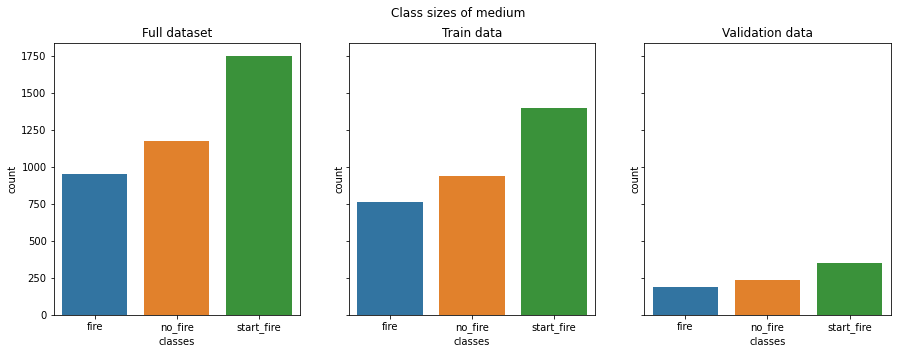

In [72]:
# Select correct preprocess function
load_preprocessing_function(classifier)

# Set transformations on input training data
if enable_data_augmentation:
  print("augmenting")
  train_datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      #rescale=1/255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=validation_split,
      preprocessing_function=preprocess_input
  )
else:
  print("not augmenting")
  train_datagen = ImageDataGenerator(
      #rescale=1/255,
      validation_split=validation_split,
      preprocessing_function=preprocess_input
  )
# No transformations on test data
test_datagen = ImageDataGenerator(
    rescale=1/255,
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=nbr_batch_size,
    class_mode='categorical',
    subset='training',
    seed=155,
    shuffle=True, 
    #save_to_dir='Augm/train',
    #save_prefix="Augm_train_",
    #save_format="jpeg"
)
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=nbr_batch_size,
    class_mode='categorical',
    subset='validation',
    seed=155,
    shuffle=True, 
    #save_to_dir='Augm/val',
    #save_prefix="Augm_val_",
    #save_format="jpeg"
)


# Our dataset is imbalanced (start_fire class has few entries in comparison
# with the other classes). We deal with this
# problem by generating class weights and passing them to the model
# at training time. The model will use the class weights to adjust
# how it trains so that each class is considered equally important to
# get right, even if the actual distribution of images is highly 
# variable.
all_labels = np.concatenate((train_generator.classes,validation_generator.classes),axis=None)
class_weights = {i:len(all_labels)/np.count_nonzero(all_labels == i) for i in train_generator.class_indices.values()}
print("Class weights: {} - {}".format(list(train_generator.class_indices.keys()),
                                      list(class_weights.values())))


#Plot sample data class sizes
fig,axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Class sizes of '+dataset_name)
plot_class_size(all_labels,train_generator.class_indices,"Full dataset",axes[0])
plot_class_size(train_generator.classes,train_generator.class_indices,"Train data",axes[1])
plot_class_size(validation_generator.classes,train_generator.class_indices,"Validation data",axes[2])

# **7. Choose model**

##**7.1 Inception V3**##

In [73]:
if classifier=="inceptionv3-frozen":
  # INCEPTION V3
  base_model = tf.keras.applications.InceptionV3(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=(image_size[0],image_size[1],3),
      pooling=None,
  )

  # Suffix layers at the end of the base model
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024,activation="relu"))
  #model.add(Dropout(dropout_factor,name="Dropout layer"))
  model.add(Dense(nb_classes,activation="softmax"))

  # Freeze base model parameters
  ## Only train parameters of last two Dense layers
  for layer in model.layers[0].layers:
      layer.trainable = False
  model.layers[0].trainable = False


In [74]:
if classifier=="inceptionv3-open":
  # INCEPTION V3
  base_model = tf.keras.applications.InceptionV3(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=(image_size[0],image_size[1],3),
      pooling=None,
  )

  # Suffix layers at the end of the base model
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024,activation="relu"))
  #model.add(Dropout(dropout_factor,name="Dropout layer"))
  model.add(Dense(nb_classes,activation="softmax"))

  # Freeze base model parameters
  ## Only train parameters of last two Dense layers
  for layer in model.layers[0].layers:
      layer.trainable = True
  model.layers[0].trainable = True

##**7.2 VGG16**##

In [75]:
if classifier=="vgg16":
  base_model = VGG16(
      weights='imagenet', 
      include_top=False, 
      input_shape=(224,224,3)
  )

  # Suffix layers at the end of the base model
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024,activation="relu"))
  #model.add(Dropout(dropout_factor,name="Dropout layer"))
  model.add(Dense(nb_classes,activation="softmax"))

  # Freeze VGG16 parameters
  ## Only train parameters of last two Dense layers
  for layer in model.layers[0].layers:
      layer.trainable = False
  model.layers[0].trainable = False

##**7.3 3-conv-3-dense**

In [76]:
if classifier=="3c3d":
  # https://towardsdatascience.com/early-fire-detection-system-using-deep-learning-and-opencv-6cb60260d54a
  model = Sequential([
  tf.keras.layers.Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(224, 224, 3)), tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides=(2,2)),
  tf.keras.layers.Conv2D(256, (5,5), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides=(2,2)),
  tf.keras.layers.Conv2D(384, (5,5), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(nb_classes, activation='softmax')])

##**7.4 InceptionV3 variant**

In [77]:
if classifier=="inceptionv3-variant":
  # https://towardsdatascience.com/early-fire-detection-system-using-deep-learning-and-opencv-6cb60260d54a
  input_tensor = tf.keras.layers.Input(shape=(224, 224, 3))
  base_model = tf.keras.applications.inception_v3.InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(2048, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = Dense(3, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  for layer in base_model.layers:
    layer.trainable = False

##**7.5 EfficienNetB0**

In [78]:
if classifier=="EfficientNetB0":
  print("EfficientNetB0")
  inputs = keras.Input(shape=(224,224,3))
  base_model=tf.keras.applications.EfficientNetB0(
    input_tensor=inputs,
    include_top=False,
    weights="imagenet",
    drop_connect_rate=0.4
    )
  
  #freeze the base model
  base_model.trainable = False

  #new top layer
  x = base_model(inputs, training=False) ###!!!! check training = False for Batchnormalisation
  x = GlobalAveragePooling2D()(base_model.output)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  outputs = Dense(3, activation='softmax')(x)
  model = Model(inputs, outputs)


  #The first step to transfer learning is to freeze all layers and train only the top layers. 
  #For this step, a relatively large learning rate (1e-2) can be used. 
  #The second step is to unfreeze a number of layers and fit the model using smaller learning rate.
  #Tips for fine tuning EfficientNet
  #On unfreezing layers:
  #The BathcNormalization layers need to be kept frozen (more details). If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy.
  #In some cases it may be beneficial to open up only a portion of layers instead of unfreezing all. This will make fine tuning much faster when going to larger models like B7.
  #Each block needs to be all turned on or off. This is because the architecture includes a shortcut from the first layer to the last layer for each block. Not respecting blocks also significantly harms the final performance.
  #Some other tips for utilizing EfficientNet:
  #Larger variants of EfficientNet do not guarantee improved performance, especially for tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet chosen, the harder it is to tune hyperparameters.
  #EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch, but not so much for transfer learning.
  #Do not use the RMSprop setup as in the original paper for transfer learning. The momentum and learning rate are too high for transfer learning. It will easily corrupt the pretrained weight and blow up the loss. A quick check is to see if loss (as categorical cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same epoch. If so, the initial learning rate/momentum is too high.
  #Smaller batch size benefit validation accuracy, possibly due to effectively providing regularization.

EfficientNetB0
16711680/16705208 [==============================] - 0s 0us/step


#**Show model**##

In [79]:
len(model.layers)

241

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

#**8. Fit model**##

In [ ]:
# recompiler le modèle
model.compile(
    loss='categorical_crossentropy',
    optimizer=model_optimizer,
    metrics=['accuracy']
) 

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(len(train_generator.filenames) // nbr_batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(len(validation_generator.filenames) // nbr_batch_size),
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=early_stopping_patience,
                      restore_best_weights=True,
                      monitor="val_loss"),
    ],
    verbose=1
)

# plot accuracy graph
plot_history_accuracy(history)

Epoch 1/50
96/96 [==============================] - 97s 1s/step - loss: 0.8996 - accuracy: 0.8942 - val_loss: 0.6066 - val_accuracy: 0.7474
Epoch 2/50
96/96 [==============================] - 99s 1s/step - loss: 0.4320 - accuracy: 0.9505 - val_loss: 0.5285 - val_accuracy: 0.8060
Epoch 3/50
96/96 [==============================] - 97s 1s/step - loss: 0.3220 - accuracy: 0.9655 - val_loss: 0.5348 - val_accuracy: 0.8255
Epoch 4/50
21/96 [=====>........................] - ETA: 59s - loss: 0.2918 - accuracy: 0.9702 

#**Fine-tuning model**##

Epoch 1/50
12/79 [===>..........................] - ETA: 15s - loss: 1.6513 - accuracy: 0.8646

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


46/79 [================>.............] - ETA: 9s - loss: 2.2486 - accuracy: 0.8122

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


79/79 [==============================] - 32s 409ms/step - loss: 2.1710 - accuracy: 0.8083 - val_loss: 0.4491 - val_accuracy: 0.8487
Epoch 2/50
79/79 [==============================] - 31s 390ms/step - loss: 1.7792 - accuracy: 0.8211 - val_loss: 0.4639 - val_accuracy: 0.8684
Epoch 3/50
79/79 [==============================] - 31s 392ms/step - loss: 0.8920 - accuracy: 0.9089 - val_loss: 0.1123 - val_accuracy: 0.9671
Epoch 4/50
79/79 [==============================] - 32s 399ms/step - loss: 1.1374 - accuracy: 0.8962 - val_loss: 0.0981 - val_accuracy: 0.9737
Epoch 5/50
79/79 [==============================] - 31s 395ms/step - loss: 0.9387 - accuracy: 0.9010 - val_loss: 0.2736 - val_accuracy: 0.8947
Epoch 6/50
79/79 [==============================] - 31s 395ms/step - loss: 0.8749 - accuracy: 0.9026 - val_loss: 0.1091 - val_accuracy: 0.9605
Epoch 7/50
79/79 [==============================] - 31s 397ms/step - loss: 1.0372 - accuracy: 0.8978 - val_loss: 0.2445 - val_accuracy: 0.9211
Epoch 8/50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


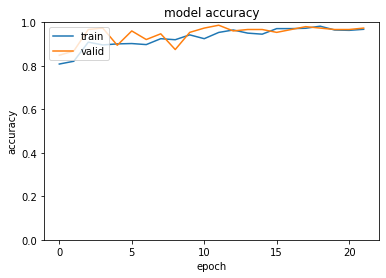

In [ ]:
if tuning :
  # We unfreeze the top 20% layers while leaving BatchNorm layers frozen
  for layer in model.layers[-math.ceil(0.20*len(model.layers)):]:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = True

  # recompiler le modèle
  model.compile(
      loss='categorical_crossentropy',
      optimizer=model_optimizer,
      metrics=['accuracy']
  ) 

  # Fit the model
  history = model.fit(
      train_generator,
      steps_per_epoch=math.ceil(len(train_generator.filenames) // nbr_batch_size),
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=math.ceil(len(validation_generator.filenames) // nbr_batch_size),
      class_weight=class_weights,
      callbacks=[
          EarlyStopping(patience=early_stopping_patience,
                        restore_best_weights=True,
                        monitor="val_loss"),
          ReduceLROnPlateau(patience=reduce_plateau_patience,
                            factor=0.2,
                            min_lr=1e-5,
                            verbose=1,
                            monitor="val_loss")
      ],
      verbose=1
  )

  # plot accuracy graph
  plot_history_accuracy(history)

#**9. Save model, plot structure to image and show summary table**


In [ ]:
#Save model to .h5 file for later usage
model.save(result_path+"/"+dataset_name+"-"+classifier+".h5")
tf.keras.utils.plot_model(model, to_file=result_path+"/"+dataset_name+"-"+classifier+".png", show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

#**10. Tester le modèle final avec une image de test: "fire.jpg" et "no_fire.jpg"**

In [ ]:
files.upload()

Saving 00000325.jpg to 00000325.jpg


{'00000325.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xed4bPhotoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x00\x0f\x1c\x01Z\x00\x03\x1b%G\x1c\x02\x00\x00\x02\x00\x00\x008BIM\x04%\x00\x00\x00\x00\x00\x10\xcd\xcf\xfa}\xa8\xc7\xbe\t\x05pv\xae\xaf\x05\xc3N8BIM\x04:\x00\x00\x00\x00\x00\xe5\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00\x00\x0bprintOutput\x00\x00\x00\x05\x00\x00\x00\x00PstSbool\x01\x00\x00\x00\x00Inteenum\x00\x00\x00\x00Inte\x00\x00\x00\x00Clrm\x00\x00\x00\x0fprintSixteenBitbool\x00\x00\x00\x00\x0bprinterNameTEXT\x00\x00\x00\x01\x00\x00\x00\x00\x00\x0fprintProofSetupObjc\x00\x00\x00\x0c\x00P\x00r\x00o\x00o\x00f\x00 \x00S\x00e\x00t\x00u\x00p\x00\x00\x00\x00\x00\nproofSetup\x00\x00\x00\x01\x00\x00\x00\x00Bltnenum\x00\x00\x00\x0cbuiltinProof\x00\x00\x00\tproofCMYK\x008BIM\x04;\x00\x00\x00\x00\x02-\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00\x00\x12printOutputOptions\x00\x00\x00\x17\x00\x00\x00\x00Cptnbool\x00\x00\x00\x00\x00Clbrbool\x00\x00\x0

Top 1 ====================
Class name: fire
Probability: 58.82%
Top 2 ====================
Class name: no_fire
Probability: 39.64%
Top 3 ====================
Class name: start_fire
Probability: 1.54%


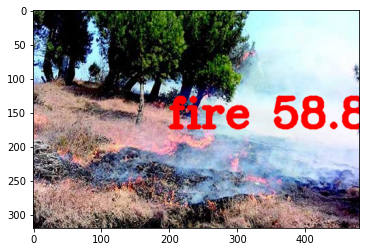

In [ ]:
%matplotlib inline
# load class names
classes = list(train_generator.class_indices.keys())

image_path = "00000325.jpg"
top_n=3
img = image.load_img(image_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# predict
pred = model.predict(x)[0]
result = [(classes[i], float(pred[i]) * 100.0) for i in range(len(pred))]
result.sort(reverse=True, key=lambda x: x[1])

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
font = cv2.FONT_HERSHEY_COMPLEX 

for i in range(top_n):
    (class_name, prob) = result[i]
    textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
    textX = (img.shape[1] - textsize[0]) / 2
    textY = (img.shape[0] + textsize[1]) / 2
    if (i == 0) :
        cv2.putText(img, class_name+" "+str(round(prob,2))+"%", (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
    print("Top %d ====================" % (i + 1))
    print("Class name: %s" % (class_name))
    print("Probability: %.2f%%" % (prob))
plt.imshow(img)
plt.show()